# Práctica NLP

Este trabajo presenta un sistema de clasificación binaria de sentimientos aplicado a reviews de libros de Amazon. El objetivo es predecir si una review es positiva o negativa basándose en el texto escrito por los usuarios.

## 1. Descarga y exploración del corpus

### 1.1. Descargar datos

Para la práctica se ha descargado el subset de 5 core de Books del enlace: https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/categoryFilesSmall/Books_5.json.gz

El fichero contiene 27.164.983 reviews, una por línea en formato JSON.

Inicialmente se intentó descargarlo con la librería [requests](https://pypi.org/project/requests/), pero en Google Colab el proceso consumía demasiada memoria. Por ello, se descargó directamente al disco mediante wget.

Para obtener un corpus balanceado, se creó una función que guarda 1000 registros de cada puntuación ('overall') del 1 al 5. También fue necesario ajustarla para comprobar que la ejecución funcionaba correctamente y no se alargaba en exceso. Con este procedimiento se evita tener que aplicar oversampling o undersampling más adelante, técnicas que pueden introducir complicaciones.


In [2]:
URL = "https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/categoryFilesSmall/Books_5.json.gz"
INPUT_FILE = "Books_5.json.gz"
OUTPUT_FILE = "Books_balanced_5000.json"
SAMPLES_PER_RATING = 1000 # cuantos registros quiero por rating (1-5)

In [3]:
!wget $URL

--2025-12-02 14:40:30--  https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/categoryFilesSmall/Books_5.json.gz
Resolving mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)... 169.228.63.88
Connecting to mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)|169.228.63.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7091160204 (6.6G) [application/gzip]
Saving to: ‘Books_5.json.gz’

Books_5.json.gz     100%[===================>]   6.60G  99.4MB/s    in 82s     

2025-12-02 14:41:52 (82.3 MB/s) - ‘Books_5.json.gz’ saved [7091160204/7091160204]



In [4]:
# Imports necesarios
import json
import gzip
import os
from collections import Counter
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def balance_dataset(input_file, samples_per_rating, output_file):
    """Lee el archivo comprimido con gz y selecciona N reviews de cada rating (1-5)"""
    reviews_by_rating = {1.0: [], 2.0: [], 3.0: [], 4.0: [], 5.0: []}
    target_ratings = [1.0, 2.0, 3.0, 4.0, 5.0]

    lines_processed = 0

    # Leer y agregar al diccionario de reviews
    with gzip.open(input_file, 'rt', encoding='utf-8') as f:
        for line in f:
            lines_processed += 1

            # Print para ver progreso
            if lines_processed % 500000 == 0:
                counts = {r: len(reviews_by_rating[r]) for r in target_ratings}
                print(f"Procesadas {lines_processed:,} líneas. Counts: {counts}")

            try:
                review = json.loads(line.strip())
                rating = review.get('overall')

                if rating in target_ratings and len(reviews_by_rating[rating]) < samples_per_rating:
                    reviews_by_rating[rating].append(review)

                # Salir cuando tengamos suficientes
                if all(len(reviews_by_rating[r]) >= samples_per_rating for r in target_ratings):
                    print(f"Completado tras {lines_processed:,} líneas")
                    break
            except:
                continue

    # Juntar todo y mezclar
    all_reviews = []
    for rating in target_ratings:
        all_reviews.extend(reviews_by_rating[rating])

    random.seed(42)
    random.shuffle(all_reviews)

    # Guardar fichero final
    with open(output_file, 'w', encoding='utf-8') as f:
        for review in all_reviews:
            f.write(json.dumps(review) + '\n')

    print(f"{len(all_reviews)} reviews guardadas en {output_file}")
    return output_file

balance_dataset(INPUT_FILE, SAMPLES_PER_RATING, OUTPUT_FILE)

Completado tras 30,352 líneas
5000 reviews guardadas en Books_balanced_5000.json


'Books_balanced_5000.json'

In [6]:
with open("Books_balanced_5000.json", 'r') as f:
    print([next(f) for _ in range(3)])

['{"overall": 2.0, "vote": "13", "verified": false, "reviewTime": "07 23, 2000", "reviewerID": "A2E7MZBNH11GL4", "asin": "0002227541", "style": {"Format:": " Hardcover"}, "reviewerName": "Elsie Wilson", "reviewText": "Formulaic MacLean story.  Starts with Amsterdam airoport flooded, as a way of getting the readers\' attention, moves to further floods (dikes blasted) in the Netherlands and threats of even more, as a way of drawing attention  to the terrorists\' demands.  The hero is a typical MacLean hero, just a  little too good, fluent in languages, explosives, criminal behaiviour,  organisation, self-confidence, yet still not the top man in his  organisation (the Amsterdam police force); a natural gentleman, concerned  for and afraid of his sister.  The ladies in the novel are simply the most  beautiful available or imaginable; and perfect ladies.  The government  figures are, except for one, dolts and incapable of understanding a simple  statement.  The terrorists are, in this case,

### 1.2. Cargar datos

In [7]:
def load_product_reviews(datasets_path):
    """Carga reviews de un fichero JSON"""
    reviews_dict = {}
    filepath = datasets_path

    with open(filepath, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f):
            if not line.strip():
                continue
            review = json.loads(line.strip())
            reviews_dict[idx] = {
                'rating': review.get('overall'),
                'verified': review.get('verified'),
                'review_time': review.get('reviewTime'),
                'reviewer_id': review.get('reviewerID'),
                'asin': review.get('asin'),
                'style': review.get('style'),
                'reviewer_name': review.get('reviewerName'),
                'review_text': review.get('reviewText'),
                'summary': review.get('summary'),
                'unix_time': review.get('unixReviewTime')
            }

    return reviews_dict

reviews = load_product_reviews(OUTPUT_FILE)

In [8]:
# Crear dataframe
reviews_text = []
reviews_sentiment = []

for review in reviews.values():
    reviews_text.append(review.get('review_text'))
    reviews_sentiment.append(review.get('rating'))

df = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_sentiment
})

# Comprobación básica
print(f"DataFrame con {len(df):,} reviews")
df.head()

DataFrame con 5,000 reviews


,review,sentiment
0,Formulaic MacLean story. Starts with Amsterda...,2.0
1,I read Storm of Swords and was excited to get ...,2.0
2,Ranking books of this nature is an interesting...,5.0
3,I have read and enjoyed two other books in the...,2.0
4,This was my favorite childhood book and the ea...,5.0


### 1.3. Análisis exploratorio

#### 1.3.1. Tokenizar solo para EDA

Se convierte a minúsculas y se tokeniza por espacios como se hacía en el notebook 9 para una visualización rápida.



In [9]:
splitted_reviews = df['review'].str.lower().str.split()
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)
vocabulary_ = Counter(words)

#### 1.3.2. Distribución de reviews por rating

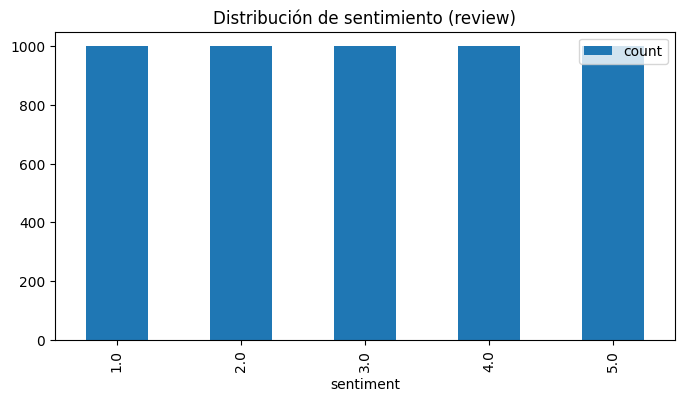

In [10]:
aux_df = pd.DataFrame(df['sentiment'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Distribución de sentimiento (review)', figsize=(8, 4))

#### 1.3.3. Cardinalidad del vocabulario

In [11]:
print(f"\nPalabras únicas: {len(vocabulary_):,}")
print(f"Total de tokens: {sum(vocabulary_.values()):,}")
print(f"Promedio por review: {sum(vocabulary_.values()) / len(df):.1f}")


Palabras únicas: 44,733
Total de tokens: 580,123
Promedio por review: 116.0


In [12]:
# palabras más frecuentes
wf_most_common = vocabulary_.most_common(20)

print(f"Palabras más frecuentes")
print(wf_most_common)

Palabras más frecuentes
[('the', 33747), ('and', 16956), ('of', 15187), ('to', 15011), ('a', 14757), ('i', 11390), ('is', 9679), ('in', 8831), ('this', 7738), ('it', 7110), ('that', 6735), ('was', 4959), ('for', 4933), ('book', 4757), ('as', 4344), ('but', 4241), ('with', 4147), ('not', 3570), ('are', 3229), ('have', 3049)]


In [13]:
from nltk import ngrams
from nltk.probability import FreqDist

# ngrams frecuentes
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

print(f"Bigrams más frecuentes")
print(bigrams_freq_.most_common(10))
print(f"\nTrigrams más frecuentes")
print(trigrams_freq_.most_common(10))

Bigrams más frecuentes
[(('of', 'the'), 4152), (('in', 'the'), 2558), (('this', 'book'), 1757), (('and', 'the'), 1508), (('is', 'a'), 1372), (('to', 'the'), 1355), (('the', 'book'), 1286), (('it', 'is'), 1112), (('to', 'be'), 1099), (('this', 'is'), 966)]

Trigrams más frecuentes
[(('this', 'book', 'is'), 357), (('this', 'is', 'a'), 303), (('one', 'of', 'the'), 268), (('of', 'the', 'book'), 253), (('a', 'lot', 'of'), 230), (('the', 'book', 'is'), 229), (('it', 'is', 'a'), 194), (('some', 'of', 'the'), 192), (('the', 'end', 'of'), 179), (('this', 'book', 'was'), 172)]


#### 1.3.4. Nube de palabras

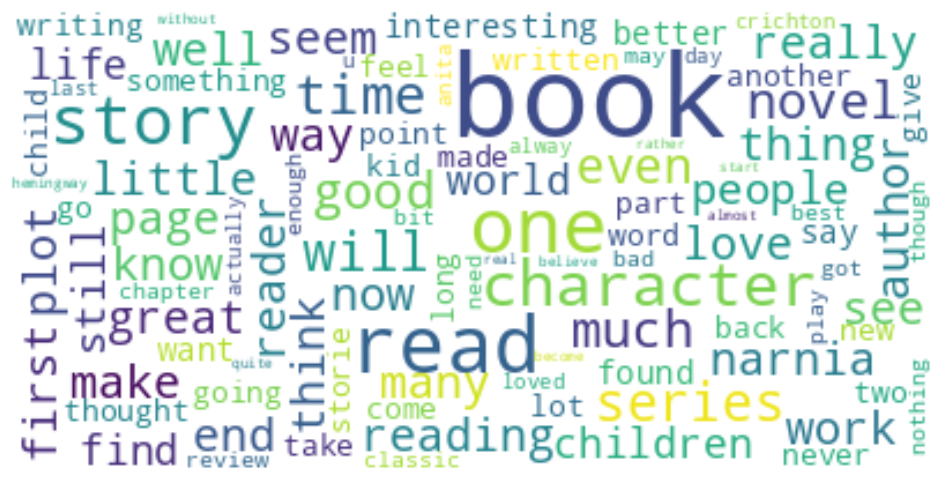

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

all_text = ' '.join(df['review'].dropna().values)
words_list = all_text.lower().strip().split()
plot_word_cloud(words_list)

#### 1.3.5. Visualización de word embeddings calculados con Word2Vec

In [15]:
!pip install gensim

from gensim.models import Word2Vec

sentences = [review.lower().split() for review in df['review'].dropna()]

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,
    epochs=10
)

print(f"Vocabulario: {len(w2v_model.wv)} palabras")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 24.5 MB/s eta 0:00:00
Vocabulario: 8136 palabras


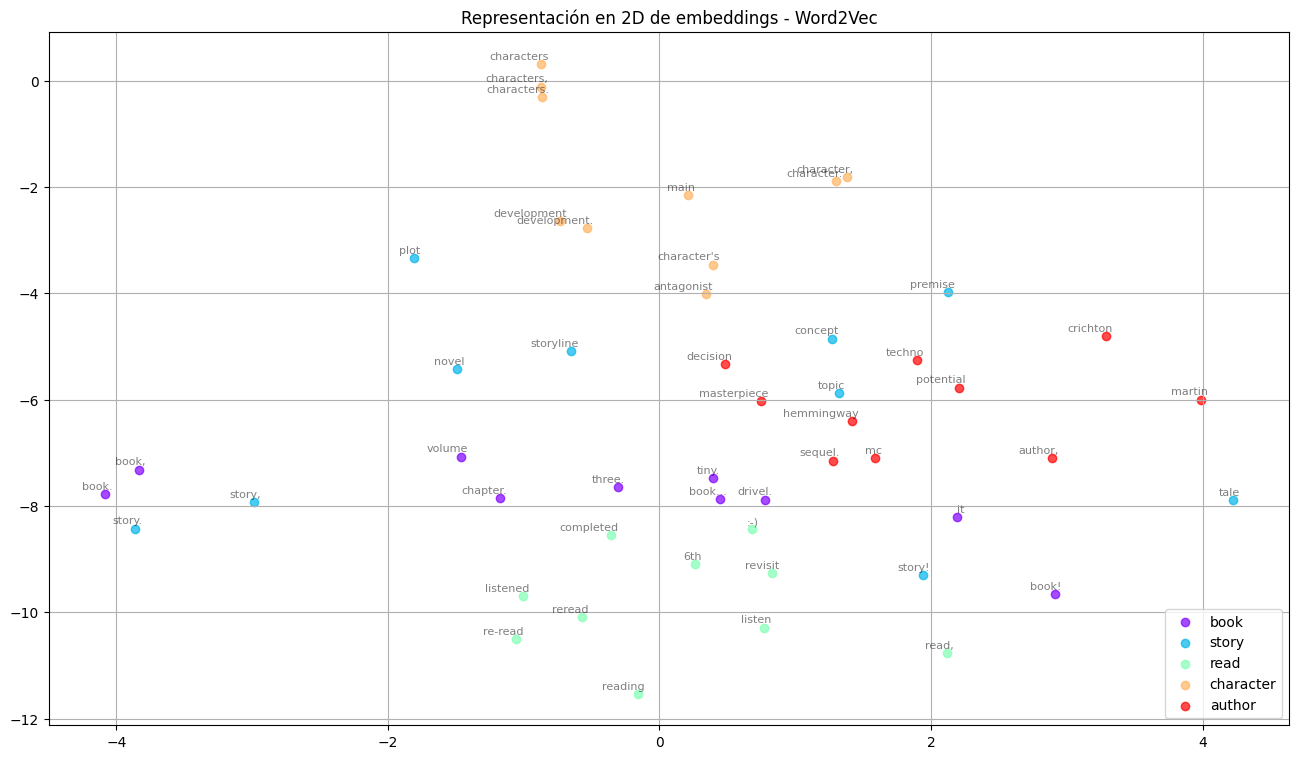

In [16]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

keys = ['book', 'story', 'read', 'character', 'author']

embedding_clusters = []
word_clusters = []

for word in keys:
    if word in w2v_model.wv:
        embeddings = []
        words = []
        for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
            words.append(similar_word)
            embeddings.append(w2v_model.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

# Reducir dimensionalidad
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

tsne_model = TSNE(perplexity=15, n_components=2, init='pca', max_iter=3500, random_state=32)
embeddings_2d = np.array(tsne_model.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

# Visualizar
plt.figure(figsize=(16, 9))
colors = cm.rainbow(np.linspace(0, 1, len(keys)))

for label, embeddings, words, color in zip(keys, embeddings_2d, word_clusters, colors):
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=[color], alpha=0.7, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=8)

plt.legend(loc=4)
plt.grid(True)
plt.title('Representación en 2D de embeddings - Word2Vec')
plt.show()

#### 1.3.5. Observaciones de EDA

* He cargado los datos de una manera que estén balanceados: 1000 registros por puntuación de 1 a 5. He dejado la gráfica de distribución, pero no merecía la pena visualizar ratings "negativos vs positivos" porque ya sabemos cómo va a ser la distribución.
* Hay un vocabulario bastante grande (44.733 palabras únicas) teniendo en cuenta que solo he elegido 5000 registros, con una media de 116 palabras por review.
* Los datos de frecuencia y n-grams no me han servido de mucho. Sin usar stopwords salen muchos artículos y conectores. Era de esperar haciendo una tokenización sencilla.
* Aunque haya solo 5000 registros, el Word2Vec ha salido bastante coherente.

In [17]:
# Guardar el dataframe para el siguiente notebook
import pickle

with open('data_para_ejecutar_ejercicio2.pkl', 'wb') as f:
    pickle.dump(df, f)